In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import os
import re 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%pip install category_encoders
import category_encoders as ce


import math 
from torch.nn import Module
from torch.nn import ModuleList
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


Note: you may need to restart the kernel to use updated packages.


In [2]:
## setting up the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Feature engineering
Data exploration has been conducted in the previous [ML based notebook](https://www.kaggle.com/code/sabyasachi96/tps-september2024-s4e9-ml). Anova supported target encoding of the categorical variable, helped in reducing the feature space making the DL training less cumbersome and easy. 
[All different encoding types](https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b#:~:text=Count%20encoding%20or%20frequency%20encoding,category%20and%20the%20target%20variable)

In [4]:
def nullValuesCols(df):
    columns_with_null = df.columns[df.isnull().any()]
    print(f'Total null values in the dataset {df.isnull().sum().sum()}')
    print(f'columns {columns_with_null}')
    for col in columns_with_null:
        print(f' -- Null value for column {col}: {df[col].isnull().sum()}')
    
    print(f'Total null values in the dataset {df.isnull().sum().sum()}')
    print('\n\n')
    
def fill_null_with_median_or_mode(df):
    print('Before filling the null values:', df.isnull().sum().sum())
    
    # Loop through each column in the DataFrame
    for column in df.columns:
        if df[column].dtype.name in ['float64', 'int64']:
            # For numerical columns, use median
            median_value = df[column].median()
            df[column] = df[column].fillna(median_value)
        elif df[column].dtype == 'object':
            # For object (categorical) columns, use mode
            mode_value = df[column].mode().iloc[0]  # Get the first mode if there are multiple
            df[column] = df[column].fillna(mode_value)
    
    print('After filling the null values:', df.isnull().sum().sum())
    
    return df


def feature_engineering(dataframe):
    df = dataframe.copy()
    ## extract important features 
    df['horse_power'] = df['engine'].str.extract(r'(\d+\.\d+)HP')
    df['horse_power'] = df['horse_power'].astype(float)
    
    df['liters'] = df['engine'].str.extract(r'(\d+\.\d+)L')
    df['liters'] = df['liters'].astype(float)
    
    df['cylinders'] = df['engine'].str.extract(r'(\d+) Cylinder')
    df['cylinders'] = df['cylinders'].astype(float)
    
    df['turbo'] = df['engine'].str.extract(r'(turbo\w*)' , flags=re.IGNORECASE)
    df['turbo'] = np.where(df['turbo'] == 'Turbo', 1, 0)
    
    df['clean_title'] = np.where(df['clean_title'] == 'Yes', 1, 0)
    df['accident'] = np.where(df['accident'] == 'At least 1 accident or damage reported', 1, 0)
    
    ## prepare new features indicating car features
    df['car_age'] = 2024 - df['model_year']
    df['Power_to_Weight_Ratio'] = df['horse_power'] / df['liters']
    df['milage_per_year'] = np.where(df['car_age'] == 0, df['milage'], df['milage'] / df['car_age'])
    
    df.drop(columns = ['engine', 'model_year'], inplace = True)
    
    df = fill_null_with_median_or_mode(df)
    
    return df
    
    
train_df = feature_engineering(train)
test_df = feature_engineering(test)

print(train_df.info())
train_df.head()

Before filling the null values: 128297
After filling the null values: 0
Before filling the null values: 85306
After filling the null values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     188533 non-null  int64  
 1   brand                  188533 non-null  object 
 2   model                  188533 non-null  object 
 3   milage                 188533 non-null  int64  
 4   fuel_type              188533 non-null  object 
 5   transmission           188533 non-null  object 
 6   ext_col                188533 non-null  object 
 7   int_col                188533 non-null  object 
 8   accident               188533 non-null  int64  
 9   clean_title            188533 non-null  int64  
 10  price                  188533 non-null  int64  
 11  horse_power            188533 non-null  float64
 12 

,id,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,horse_power,liters,cylinders,turbo,car_age,Power_to_Weight_Ratio,milage_per_year
0,0,MINI,Cooper S Base,213000,Gasoline,A/T,Yellow,Gray,0,1,4200,172.0,1.6,4.0,0,17,107.500000,12529.411765
1,1,Lincoln,LS V8,143250,Gasoline,A/T,Silver,Beige,1,1,4999,252.0,3.9,8.0,0,22,64.615385,6511.363636
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,A/T,Blue,Gray,0,1,13900,320.0,5.3,8.0,0,22,60.377358,6215.045455
3,3,Genesis,G90 5.0 Ultimate,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,0,1,45000,420.0,5.0,8.0,0,7,84.000000,2785.714286
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,7-Speed A/T,Black,Beige,0,1,97500,208.0,2.0,4.0,0,3,104.000000,2462.666667


In [5]:
def encoding_scaling(datasets, _type = None):
    df = datasets[0]
    test = datasets[1].drop(['id'], axis = 1)
    x = df.drop(['id', 'price'], axis = 1)
    y = df['price']
    
    # Split into training and testing sets
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 42)

    
    object_cols = df.select_dtypes(include = ['object']).columns
    if _type == 'target_encoding':
        encoder = ce.TargetEncoder(cols = object_cols)
    elif _type == 'frequency_encoding':
        encoder = ce.CountEncoder(cols = object_cols)
    else:
        encoder = ce.TargetEncoder(cols = object_cols)
        
    encoder.fit(X_train, y_train)
    
    X_train = encoder.transform(X_train)
    X_val = encoder.transform(X_val)
    test = encoder.transform(test)
    
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = x.columns)
    X_val = pd.DataFrame(scaler.fit_transform(X_val), columns = x.columns)
    test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)
    
    pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
 
    
    return (X_train, X_val, y_train, y_val), test

train, test = encoding_scaling([train_df, test_df])
    

## Building ANN models 

In [6]:
class carPriceNN_1(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc0 = nn.Sequential(
                        nn.Linear(input_dim, 4096),
                        nn.ReLU(),
                        nn.BatchNorm1d(4096), 
                        nn.Dropout(0.5))
        
        self.fc1 = nn.Linear(input_dim, 2048)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(2048)
        
        self.fc2 = nn.Linear(2048, 1)
        
        self.fc1_2 = nn.Sequential(
                        nn.Linear(2048, 512),
                        nn.ReLU(),
#                         nn.BatchNorm1d(512), 
                        nn.Dropout(0.3))
        
        self.fc2_2 = nn.Linear(512, 1)
        

    def forward(self, x):
#         x = self.fc0(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.fc2(x)
#         x = self.fc1_2(x)
#         x = self.fc2_2(x)
        return x
    
    
# Create an instance of the model
input_dim = train[0].shape[1] 
print(f"Input dimension: {input_dim}")
# model = carPriceNN(input_dim).to(device)

# Use torchinfo to get a summary of the model
from torchinfo import summary
summary(carPriceNN_1(input_dim).to(device), input_size=(1, input_dim)) 

Input dimension: 16


Layer (type:depth-idx)                   Output Shape              Param #
carPriceNN_1                             [1, 1]                    1,127,425
├─Linear: 1-1                            [1, 2048]                 34,816
├─ReLU: 1-2                              [1, 2048]                 --
├─BatchNorm1d: 1-3                       [1, 2048]                 4,096
├─Linear: 1-4                            [1, 1]                    2,049
Total params: 1,168,386
Trainable params: 1,168,386
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.16
Estimated Total Size (MB): 0.20

In [7]:
class carPriceNN_2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.fc1 = nn.Sequential(
                        nn.Linear(input_dim, 256),
                        nn.ReLU(),
                        nn.BatchNorm1d(256), 
                        nn.Dropout(0.5))
        
        self.fc2 = nn.Sequential(
                        nn.Linear(256, 256), 
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                        nn.Dropout(0.5))
        
        self.fc3 = nn.Sequential(
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                        nn.Dropout(0.4))
        
        self.fc4 = nn.Sequential(
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.BatchNorm1d(64),
                        nn.Dropout(0.3))

        self.fc5 = nn.Sequential(   
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.BatchNorm1d(32),
                        nn.Dropout(0.2))
            
        self.fc6 = nn.Sequential(
                        nn.Linear(32, 1))
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
#         print('fc1', x.shape)
        x = self.fc2(x)
#         print('fc2', x.shape)
        x = self.fc3(x)
#         print('fc3', x.shape)
        x = self.fc4(x)
#         print('fc4', x.shape)
        x = self.fc5(x)
#         print('fc5', x.shape)
        x = self.fc6(x)
#         print('fc6', x.shape)
        x = self.relu(x)  # Added sigmoid activation
        return x

# Create an instance of the model
input_dim = train[0].shape[1]
print(f"Input dimension: {input_dim}")
# model = carPriceNN(input_dim).to(device)

# Use torchinfo to get a summary of the model
from torchinfo import summary
summary(carPriceNN_2(input_dim).to(device), input_size=(1, input_dim))  # Changed batch size to 1

Input dimension: 16


Layer (type:depth-idx)                   Output Shape              Param #
carPriceNN_2                             [1, 1]                    --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 256]                  4,352
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─BatchNorm1d: 2-3                  [1, 256]                  512
│    └─Dropout: 2-4                      [1, 256]                  --
├─Sequential: 1-2                        [1, 256]                  --
│    └─Linear: 2-5                       [1, 256]                  65,792
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─BatchNorm1d: 2-7                  [1, 256]                  512
│    └─Dropout: 2-8                      [1, 256]                  --
├─Sequential: 1-3                        [1, 128]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│ 

In [8]:

def fcnn_Layers(startFeature, endFeature, input_dim):# = 0):
    startPower = int(math.log2(startFeature))
    endPower = int(math.log2(endFeature))
    if input_dim != 0:
        h_neuronsLayers = [input_dim]
    else:
        h_neuronsLayers = []
        
    while startFeature >= endFeature:
        h_neuronsLayers.append(startFeature)
        startFeature //= 2
    return tuple(h_neuronsLayers)#, tuple(deCh)

fcnn_list = fcnn_Layers(2048, 512, 1000)
print(fcnn_list)

class Block(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc_block = nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU(),
        nn.BatchNorm1d(out_features),
        nn.Dropout(0.5))
        
    def forward(self, x):
        fcnBlock = self.fc_block(x)
        return fcnBlock
# print(Block(64,32))

class carPriceNN_3(nn.Module):
    def __init__(self, input_dim, startFeature, endFeature, h_layers = 0):
        super().__init__() 
        self.featureLayer_lists = fcnn_Layers(startFeature, endFeature, input_dim)
        self.fcnBlock = ModuleList([Block(self.featureLayer_lists[i], self.featureLayer_lists[i+1]) 
                                  for i in range(len(self.featureLayer_lists) - 1)])
        self.relu = nn.ReLU()
        self.lastFc = nn.Linear(endFeature, 1)
    
    def forward(self, x):
        blockOutputs = []
        for block in self.fcnBlock:
            # print(block)
            x = block(x)
            blockOutputs.append(x)
        x = self.lastFc(x)
        
        return x #blockOutputs
        

from torchinfo import summary
input_dim = train[0].shape[1]
# model = carPriceNN(input_dim, 64, 1).to(device)
summary(carPriceNN_3(input_dim, 1024, 128).to(device), input_size = (1, input_dim), depth = 3)


(1000, 2048, 1024, 512)


Layer (type:depth-idx)                   Output Shape              Param #
carPriceNN_3                             [1, 1]                    --
├─ModuleList: 1-1                        --                        --
│    └─Block: 2-1                        [1, 1024]                 --
│    │    └─Sequential: 3-1              [1, 1024]                 19,456
│    └─Block: 2-2                        [1, 512]                  --
│    │    └─Sequential: 3-2              [1, 512]                  525,824
│    └─Block: 2-3                        [1, 256]                  --
│    │    └─Sequential: 3-3              [1, 256]                  131,840
│    └─Block: 2-4                        [1, 128]                  --
│    │    └─Sequential: 3-4              [1, 128]                  33,152
├─Linear: 1-2                            [1, 1]                    129
Total params: 710,401
Trainable params: 710,401
Non-trainable params: 0
Total mult-adds (M): 0.71
Input size (MB): 0.00
Forward/backward

In [9]:

def rmse(y_pred, y):
    return torch.sqrt(torch.mean((y_pred - y) ** 2))



In [10]:
from torch.utils.data import DataLoader, TensorDataset

def dataLoader(df, batch_size = 64, _type = None):
    if _type == 'train':
        x_tensor = torch.tensor(df[0].values, dtype = torch.float32)
        y_tensor = torch.tensor(df[1].values, dtype = torch.float32)
        dataset = TensorDataset(x_tensor, y_tensor)
        data_loader = DataLoader(dataset, batch_size, shuffle = True)
        return data_loader
    elif _type == 'test':
        df = torch.tensor(df.values, dtype = torch.float32)
        return df
    return 

 
X_train, X_val, y_train, y_val = train   
trainLoader = dataLoader((X_train, y_train), batch_size = 1024, _type = 'train')
valLoader = dataLoader((X_val, y_val), batch_size = 1024, _type = 'train')
_test = dataLoader(test, _type = 'test')

In [11]:
def train(epoch, train_loader, criterion, model, device):
    total_loss = 0
    start_time = time.time()
    model.train()
    
    for i, batch in enumerate(train_loader):
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred = model(x)
        
        loss = torch.sqrt(criterion(y_pred.squeeze(), y))
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    end_time = time.time()

    return total_loss/len(train_loader)

def val(epoch, val_loader, criterion, model, device = device, print_every = 0):
    total_loss = 0
    start_time = time.time()
    
    with torch.no_grad():
        model.eval()
        for i, batch in enumerate(val_loader):
            x, y = batch[0].to(device), batch[1].to(device)
            y_pred = model(x)
            
            #loss = criterion(y_pred.squeeze(), y)
            loss = torch.sqrt(criterion(y_pred.squeeze(), y))
            total_loss += loss.item()

    return total_loss/len(val_loader)

def plotResults(_train_loss, _test_loss):
    plt.figure(figsize=(10, 6))
    plt.style.use("ggplot")

    plt.plot(_train_loss, label="train_loss", marker='d')
    plt.plot(_test_loss, label="test_loss", marker='p')

    plt.title(f"Model Results") 
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return

Using device: cuda
Epoch [10/100], trainLoss: 82536.55420300388, valLoss: 80902.98943192829
Epoch [20/100], trainLoss: 72347.02375545059, valLoss: 71908.86848958333
Epoch [30/100], trainLoss: 68891.2816436531, valLoss: 68636.431640625
Epoch [40/100], trainLoss: 68773.59600593508, valLoss: 68418.24738069283
Epoch [50/100], trainLoss: 68518.45560804264, valLoss: 69110.0191830184
Epoch [60/100], trainLoss: 68687.87219900679, valLoss: 67960.32757994186
Epoch [70/100], trainLoss: 68277.85580184108, valLoss: 67505.39598473837
Epoch [80/100], trainLoss: 68204.99565467538, valLoss: 67906.82008539244
Epoch [90/100], trainLoss: 69042.17837027616, valLoss: 68446.71119488857
Epoch [100/100], trainLoss: 68359.17405523256, valLoss: 68197.35130511143


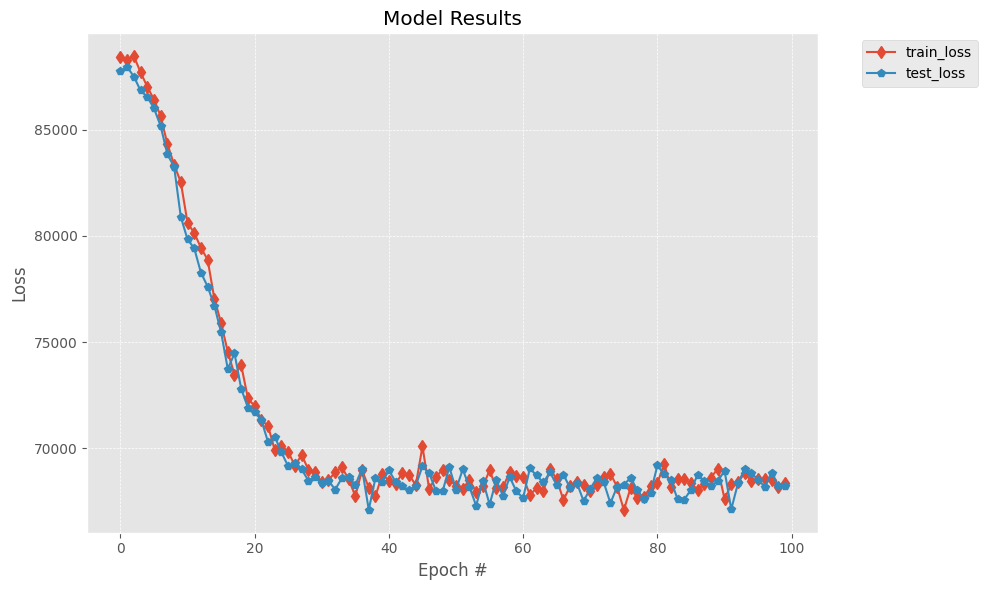

In [12]:
import time
train_loss = []
val_loss = []
Num_epochs = 100
input_dim = X_train.shape[1]
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = carPriceNN_1(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5)

for epoch in range(Num_epochs):
    loss = train(epoch, trainLoader, criterion, model, device = device)
    train_loss.append(loss)
    
    loss = val(epoch, trainLoader, criterion, model, device = device)
    val_loss.append(loss)
    
    if (epoch+1)%10 == 0:
        print(f"Epoch [{epoch+1}/{Num_epochs}], trainLoss: {train_loss[epoch]}, valLoss: {val_loss[epoch]}")

plotResults(train_loss, val_loss)
# Predict on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = _test.to(device)
    test_predictions = model(X_test_tensor).squeeze().cpu().numpy()

# Prepare the submission file
submission['price'] = test_predictions
submission.to_csv(f'{model.__class__.__name__}_submission.csv', index=False)

Using device: cuda
Epoch [10/100], trainLoss: 88275.93759084302, valLoss: 88119.60377301357
Epoch [20/100], trainLoss: 88369.49742611434, valLoss: 88189.40634084302
Epoch [30/100], trainLoss: 87661.92590237403, valLoss: 87728.10213783915
Epoch [40/100], trainLoss: 87523.01635174418, valLoss: 87224.64344113372
Epoch [50/100], trainLoss: 86872.20385174418, valLoss: 86863.42005813954
Epoch [60/100], trainLoss: 85293.34241763566, valLoss: 85666.26671511628
Epoch [70/100], trainLoss: 84848.45909035853, valLoss: 83910.57627785853
Epoch [80/100], trainLoss: 84774.07670179264, valLoss: 84573.18407824612
Epoch [90/100], trainLoss: 83020.60459060078, valLoss: 83008.39852834302
Epoch [100/100], trainLoss: 82726.78806322675, valLoss: 82212.15161700582


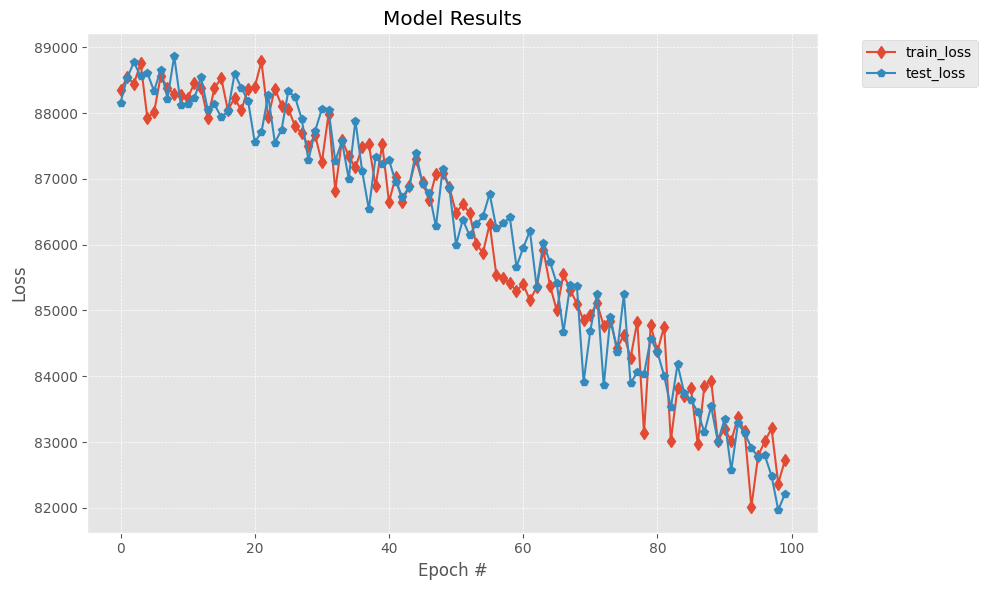

In [13]:
import time
train_loss = []
val_loss = []
Num_epochs = 100
input_dim = X_train.shape[1]
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = carPriceNN_2(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(Num_epochs):
    loss = train(epoch, trainLoader, criterion, model, device = device)
    train_loss.append(loss)
    
    loss = val(epoch, trainLoader, criterion, model, device = device)
    val_loss.append(loss)
    
    if (epoch+1)%10 == 0:
        print(f"Epoch [{epoch+1}/{Num_epochs}], trainLoss: {train_loss[epoch]}, valLoss: {val_loss[epoch]}")


plotResults(train_loss, val_loss)

# Predict on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = _test.to(device)
    test_predictions = model(X_test_tensor).squeeze().cpu().numpy()

# Prepare the submission file
submission['price'] = test_predictions
submission.to_csv(f'{model.__class__.__name__}_submission.csv', index=False)

Using device: cuda
Epoch [10/50], trainLoss: 88136.2300448159, valLoss: 87697.8894137597
Epoch [20/50], trainLoss: 85083.08342417635, valLoss: 85229.14195736434
Epoch [30/50], trainLoss: 82473.83808745156, valLoss: 134857.43883236434
Epoch [40/50], trainLoss: 80169.52056080426, valLoss: 720598.144591812
Epoch [50/50], trainLoss: 76024.50829699612, valLoss: 170263.32606589148


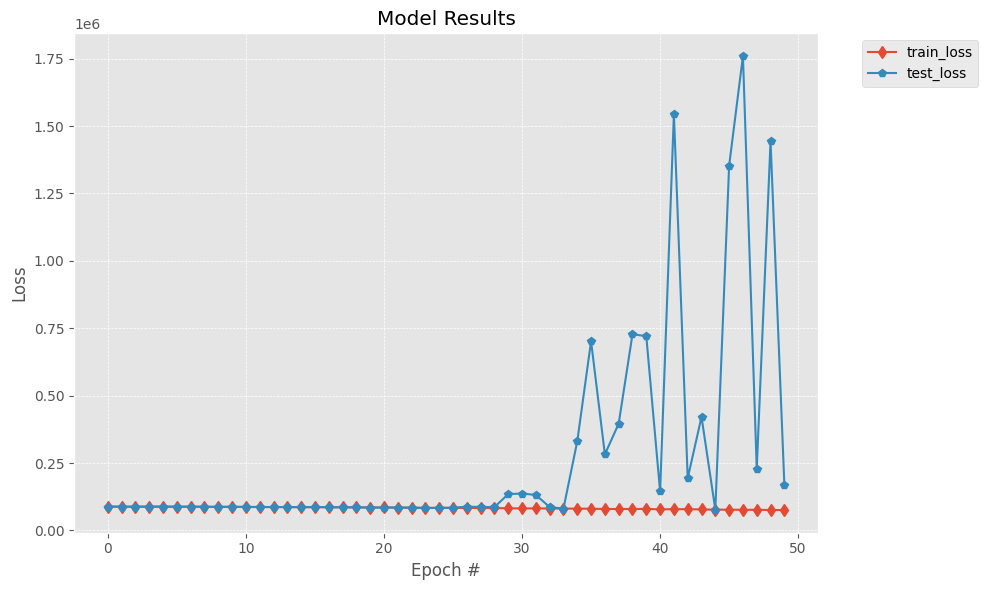

In [14]:
import time
train_loss = []
val_loss = []
Num_epochs = 50
earlyStop = 0
input_dim = X_train.shape[1]
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = carPriceNN_3(input_dim, 2048, 256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(Num_epochs):
    loss = train(epoch, trainLoader, criterion, model, device = device)
    train_loss.append(loss)
    
    loss = val(epoch, trainLoader, criterion, model, device = device)
    val_loss.append(loss)
    
    if (epoch+1)%10 == 0:
        print(f"Epoch [{epoch+1}/{Num_epochs}], trainLoss: {train_loss[epoch]}, valLoss: {val_loss[epoch]}")


plotResults(train_loss, val_loss)
# Predict on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = _test.to(device)
    test_predictions = model(X_test_tensor).squeeze().cpu().numpy()

# Prepare the submission file
submission['price'] = test_predictions
submission.to_csv(f'{model.__class__.__name__}_submission.csv', index=False)
# print(submission.head())

based on the results of all the ANN models, it was clearly that more complex models performed bad compared to a simple 2 layer ANN model. Probable reason is that the data is not complex and a simple 2 layer ANN models could capture most of the information in the data